In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("supply_chain_dataset1.csv")

In [2]:
df["Date"] = pd.to_datetime(df["Date"])

In [3]:
df = df.sort_values(["SKU_ID", "Date"])

print("\nInitial shape:", df.shape)
print(df.head())


Initial shape: (91250, 15)
           Date SKU_ID Warehouse_ID Supplier_ID Region  Units_Sold  \
0    2024-01-01  SKU_1         WH_1       SUP_8   West          10   
365  2024-01-01  SKU_1         WH_2       SUP_5   East          20   
730  2024-01-01  SKU_1         WH_3       SUP_9   West          16   
1095 2024-01-01  SKU_1         WH_4       SUP_2   East          15   
1460 2024-01-01  SKU_1         WH_5       SUP_5   East          20   

      Inventory_Level  Supplier_Lead_Time_Days  Reorder_Point  Order_Quantity  \
0                 592                       14            379               0   
365               843                        8            322               0   
730               505                        6            314               0   
1095              522                        9            333               0   
1460              640                        4            366               0   

      Unit_Cost  Unit_Price  Promotion_Flag  Stockout_Flag  Dema

In [4]:
# dropping unwanted colmns
cols_to_drop = [
    "Warehouse_ID",
    "Supplier_ID",
    "Inventory_Level",
    "Supplier_Lead_Time_Days",
    "Reorder_Point",
    "Order_Quantity",
    "Unit_Cost",
    "Unit_Price",
    "Demand_Forecast"
]

df_clean = df.drop(columns=cols_to_drop)

print("\nAfter dropping columns:", df_clean.shape)



After dropping columns: (91250, 6)


In [5]:

# eda

print("\nMissing values:")
print(df_clean.isnull().sum())

print("\nSummary stats:")
print(df_clean["Units_Sold"].describe())


Missing values:
Date              0
SKU_ID            0
Region            0
Units_Sold        0
Promotion_Flag    0
Stockout_Flag     0
dtype: int64

Summary stats:
count    91250.000000
mean        20.054564
std          9.068602
min          0.000000
25%         13.000000
50%         20.000000
75%         27.000000
max         59.000000
Name: Units_Sold, dtype: float64


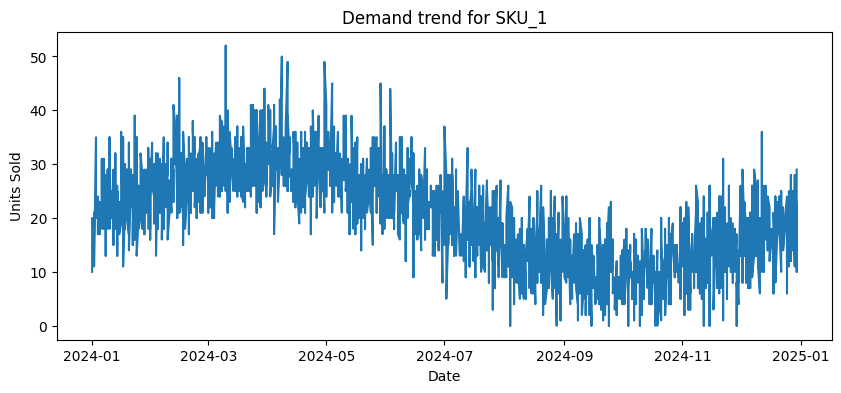

In [6]:
# plotting demand for one sample sku


sample_sku = df_clean["SKU_ID"].unique()[0]
sku_data = df_clean[df_clean["SKU_ID"] == sample_sku]

plt.figure(figsize=(10,4))
plt.plot(sku_data["Date"], sku_data["Units_Sold"])
plt.title(f"Demand trend for {sample_sku}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

In [7]:
# promotion impact check

if "Promotion_Flag" in df_clean.columns:
    promo_stats = df_clean.groupby("Promotion_Flag")["Units_Sold"].mean()
    print("\nAverage demand with/without promotion:")
    print(promo_stats)


Average demand with/without promotion:
Promotion_Flag
0    19.504977
1    24.914887
Name: Units_Sold, dtype: float64


In [8]:
# stockout impact check


if "Stockout_Flag" in df_clean.columns:
    stockout_stats = df_clean.groupby("Stockout_Flag")["Units_Sold"].mean()
    print("\nAverage demand during stockouts vs normal:")
    print(stockout_stats)



Average demand during stockouts vs normal:
Stockout_Flag
0    20.054564
Name: Units_Sold, dtype: float64


In [10]:
# filling missing dates per sku

final_dfs = []

for sku in df_clean["SKU_ID"].unique():

    temp = df_clean[df_clean["SKU_ID"] == sku]

    temp = temp.groupby("Date", as_index=False)["Units_Sold"].sum()

    temp = temp.set_index("Date")

    full_dates = pd.date_range(
        start=temp.index.min(),
        end=temp.index.max(),
        freq="D"
    )

    temp = temp.reindex(full_dates)

    temp["SKU_ID"] = sku

    temp["Units_Sold"] = temp["Units_Sold"].fillna(0)

    temp = temp.reset_index().rename(columns={"index": "Date"})

    final_dfs.append(temp)

    
df_final = pd.concat(final_dfs)

print("\nAfter filling missing dates:", df_final.shape)


After filling missing dates: (18250, 3)


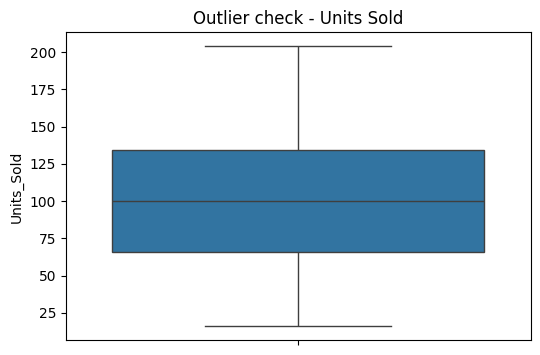

In [11]:

# outlier check

plt.figure(figsize=(6,4))
sns.boxplot(y=df_final["Units_Sold"])
plt.title("Outlier check - Units Sold")
plt.show()

In [13]:

# forecasting data:

forecasting_csv = df_final[["Date", "SKU_ID","Units_Sold"]]

forecasting_csv.to_csv("forecasting_ready_1.csv", index=False)

print("\nFinal forecasting CSV saved as: forecasting_ready_1.csv")
print(forecasting_csv.head())


Final forecasting CSV saved as: forecasting_ready_1.csv
        Date SKU_ID  Units_Sold
0 2024-01-01  SKU_1          81
1 2024-01-02  SKU_1          79
2 2024-01-03  SKU_1         126
3 2024-01-04  SKU_1         105
4 2024-01-05  SKU_1         102
